In [1]:
# Scientific Computing
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split #, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression

import pickle as p

In [2]:
# Import census demographic data - arcgis
census = pd.read_csv('census_arcgis_ca.csv', encoding='latin-1')

# Import census demographic data - 2017 ACS
census_acs = pd.read_csv('census_block_demographic.csv', skiprows=1)
slicer = census_acs['GIS Join Match Code'].str[2:]
slicer = slicer.str[0] + slicer.str[2:5] + slicer.str[6:]
census_acs['FIPS'] = slicer.astype('int64')
    
# Import QGIS combined block group
df = pd.read_csv('census_precinct_min.csv')

#calculate coverage % of each row over the whole census area
df['pct_whole'] = df['area_v']/df['area_p']

#filter out null values - 2 % is arbitrary, negative offset
df_reduc = df[df['pct_whole'] > 0.02]

# Import precinct election results, 2016
election = pd.read_csv('all_precinct_results_2016.csv', low_memory=False)

In [3]:
# Working subset
# election_tmp = election[['pct16', 'pres_clinton', 'pres_trump', 'ussenate_harris', 'ussenate_sanchez']]
# election_tmp = election_tmp.iloc[:24568] # remove precinct summations for now

election_tmp = election.iloc[:24568]

In [4]:
# Merge QGIS with precincts
cen_to_precinct = df_reduc.merge(election_tmp, on="pct16")

In [5]:
cen_to_precinct.columns

Index(['OBJECTID', 'area_c', 'pct16', 'layer', 'area_p', 'area_v', 'pct_whole',
       'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no',
       'pres_clinton_per', 'pres_trump_per', 'pres_third_per', 'pres_winner',
       'pres_margin', 'votedensity', 'prop51_yes_per', 'prop51_no_per',
       'prop52_yes_per', 'prop52_no_per', 'prop53_yes_per', 'prop53_no_per',
       'prop54_yes_per', 'prop54_no_per', '

In [6]:
# Take slice only for now; this is duplicable
# Apply pct_whole scaling for each slice in census block group
# This creates new columns scaled by precinct coverage of the census block group.

reduce = ['pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity']

manip = cen_to_precinct.copy()
manip[ reduce ] = cen_to_precinct[reduce].multiply(cen_to_precinct['pct_whole'], axis="index")


In [7]:
# GROUPBY census block group and combine
test = manip.groupby(['OBJECTID'])[reduce].sum().reset_index()

In [8]:
#len(test) # 22827
#len(census) # 23194 
len(census) - len(test) #QGIS process: census block group count that failed to match

367

In [9]:
# Now merge with ArcGIS census data.
output = test.merge(census, on=['OBJECTID'])

In [10]:
output.head()

,OBJECTID,pres_clinton,pres_trump,pres_johnson,pres_stein,pres_lariva,pres_other,ussenate_harris,ussenate_sanchez,prop51_yes,prop51_no,prop52_yes,prop52_no,prop53_yes,prop53_no,prop54_yes,prop54_no,prop55_yes,prop55_no,prop56_yes,prop56_no,prop57_yes,prop57_no,prop58_yes,prop58_no,prop59_yes,prop59_no,prop60_yes,prop60_no,prop61_yes,prop61_no,prop62_yes,prop62_no,prop63_yes,prop63_no,prop64_yes,prop64_no,prop65_yes,prop65_no,prop66_yes,prop66_no,prop67_yes,prop67_no,votedensity,STATE_FIPS,CNTY_FIPS,STCOFIPS,TRACT,BLKGRP,FIPS,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,BLACK,AMERI_ES,ASIAN,HAWN_PI,HISPANIC,OTHER,MULT_RACE,MALES,FEMALES,AGE_UNDER5,AGE_5_9,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_65_74,AGE_75_84,AGE_85_UP,MED_AGE,MED_AGE_M,MED_AGE_F,HOUSEHOLDS,AVE_HH_SZ,HSEHLD_1_M,HSEHLD_1_F,MARHH_CHD,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SQMI,Shape_Leng,Shape_Area,area_c
0,1386.00,193.72,235.21,24.31,7.59,1.46,0.00,199.93,172.54,409.99,501.46,271.79,176.53,262.05,185.13,307.67,140.57,224.68,230.23,251.85,210.17,275.93,185.44,304.40,151.82,197.06,234.10,192.28,250.19,185.94,261.37,168.91,288.42,209.15,252.36,260.13,210.38,191.06,261.41,241.28,192.82,215.81,242.42,352.76,6,83,6083,3102,1,60830031021,842,4.30,825,4.20,680,10,9,12,0,158,80,34,422,403,38,44,56,59,34,71,91,157,161,57,37,20,46.20,47.30,45.30,321,2.56,46,31,65,118,9,15,220,3.04,410,89,135,186,195.57,1.40,0.05,506526787
1,1389.00,115.30,57.64,7.12,4.14,2.02,0.00,109.40,49.62,200.94,159.41,115.82,61.41,94.31,86.24,110.46,66.78,107.40,73.80,120.74,61.08,124.88,52.46,135.14,45.16,78.13,88.33,71.20,98.73,88.66,86.06,80.70,95.96,102.49,79.87,110.70,73.73,99.59,74.42,90.48,81.10,119.68,59.50,320.98,6,83,6083,1906,5,60830019065,1143,116.90,1084,110.80,788,2,178,7,0,244,46,63,507,577,53,51,66,69,46,77,124,176,183,102,84,53,48.20,47.20,49.10,442,2.45,43,84,75,154,13,29,295,3.01,520,78,315,127,9.78,0.26,0.00,25322508
2,1390.00,185.07,198.27,19.14,5.83,0.81,0.00,189.70,142.10,345.67,465.55,235.17,160.32,209.23,182.71,259.53,139.64,212.97,191.35,248.07,169.89,229.95,178.85,273.22,138.12,179.47,210.29,156.59,234.62,161.39,236.62,164.55,247.87,209.48,205.31,215.07,207.62,171.67,233.40,193.28,191.55,204.88,208.27,426.83,6,83,6083,1903,3,60830019033,847,1486.00,822,1442.10,731,3,6,9,1,113,42,30,414,408,30,34,55,64,43,41,91,144,133,90,71,26,48.80,48.60,49.10,333,2.45,32,38,64,127,11,18,243,2.81,428,95,246,87,0.57,0.07,0.00,1483883
3,1391.00,400.18,390.19,24.67,9.48,1.41,0.00,394.02,268.97,651.15,965.17,492.93,291.41,418.94,361.27,501.31,280.33,402.62,394.46,477.33,338.45,458.07,331.07,518.70,282.51,343.87,414.22,327.53,447.48,321.45,455.82,333.85,461.55,436.32,374.71,421.29,399.07,365.25,432.81,389.20,364.58,418.31,388.07,1538.33,6,83,6083,1903,4,60830019034,2402,906.40,2027,764.90,1549,24,23,24,0,830,349,58,965,1062,129,115,139,128,114,253,247,289,216,163,116,118,41.00,36.90,44.50,834,2.37,86,198,179,191,24,50,488,3.11,937,103,379,455,2.65,0.14,0.00,6858597
4,1392.00,244.36,160.16,15.84,12.55,1.62,0.00,238.55,130.84,434.93,438.11,289.86,137.79,179.39,247.96,288.33,144.88,245.73,192.00,299.13,144.64,304.60,128.11,314.16,124.21,247.17,176.43,166.61,259.15,221.28,203.50,250.38,192.70,266.49,177.79,267.53,180.90,164.75,264.48,171.19,245.46,275.65,163.93,6.09,6,83,6083,2932,1,60830029321,609,7.30,577,7.00,396,1,0,27,0,248,140,13,318,259,42,25,39,39,34,71,79,103,90,37,13,5,39.10,39.70,38.20,204,2.83,44,12,54,59,6,9,137,3.34,249,45,73,131,82.92,0.94,0.02,214759550


In [11]:
# merge with census data ACS...
output = output.merge(census_acs, on='FIPS')

In [12]:
(output.columns)[:44]

Index(['OBJECTID', 'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity'],
      dtype='object')

In [13]:
(output.columns)[44:]

Index(['STATE_FIPS', 'CNTY_FIPS', 'STCOFIPS', 'TRACT', 'BLKGRP', 'FIPS',
       'POPULATION', 'POP_SQMI', 'POP2010', 'POP10_SQMI', 'WHITE', 'BLACK',
       'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER', 'MULT_RACE',
       'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14', 'AGE_15_19',
       'AGE_20_24', 'AGE_25_34', 'AGE_35_44', 'AGE_45_54', 'AGE_55_64',
       'AGE_65_74', 'AGE_75_84', 'AGE_85_UP', 'MED_AGE', 'MED_AGE_M',
       'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M', 'HSEHLD_1_F',
       'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD', 'FAMILIES',
       'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC', 'RENTER_OCC', 'SQMI',
       'Shape_Leng', 'Shape_Area', 'area_c', 'GIS Join Match Code',
       'County Name', 'County Code', 'Census Tract Code', 'Block Group Code',
       'Estimates: Area Name', 'Estimates: Total',
       'Estimates: Not Hispanic or Latino',
       'Estimates: Not Hispanic or Latino: White alone',
       'Estimates: Not Hispanic or

In [14]:
#Without 2% filter:
#clinton   8984948.95
#trump     4609906.59
#harris    7708206.55
#sanchez   4879410.88

#Parse results:
#clinton   8916878.19
#trump     4576116.92
#harris    7649879.62
#sanchez   4843210.37

#Actual:
#clinton    8753788
#trump      4483810
#harris     7542753
#sanchez    4701417

# Total slippage:
# (8916878 - 8753788) / 8753788 = 0.0186307916070163
# (4576116 - 4483810) / 4483810 = 0.020586510133123393

In [15]:
# Create new columns

output['pct_hispanic'] = output['HISPANIC']/output['POPULATION']
output['pct_asian'] = output['ASIAN']/output['POPULATION']
output['pct_black'] = output['BLACK']/output['POPULATION']
output['pct_white'] = output['Estimates: Not Hispanic or Latino: White alone'] / output['Estimates: Total']
#different methodology

output['pct_sanchez'] = output['ussenate_sanchez']/(output['ussenate_harris'] + output['ussenate_sanchez'])
output['pct_trump'] = output['pres_trump']/(output['pres_trump'] + output['pres_clinton'] + 
                                            output['pres_johnson'] + output['pres_stein'] +
                                            output['pres_lariva'] + output[ 'pres_other'])
output['pct_clinton'] = output['pres_clinton']/(output['pres_trump'] + output['pres_clinton'] + 
                                            output['pres_johnson'] + output['pres_stein'] +
                                            output['pres_lariva'] + output[ 'pres_other'])

prop_list = ['prop' + str(num) for num in [i for i in range(51,68)]]

for i in prop_list:
    y = i + '_yes'
    n = i + '_no'
    pct_y = 'pct_' + i + '_yes'
    output[pct_y] = output[y]/(output[y] + output[n])

# output['pct_prop58_yes'] = output['prop58_yes']/(output['prop58_yes'] + output['prop58_no'])
# output['pct_prop59_yes'] = output['prop59_yes']/(output['prop59_yes'] + output['prop59_no'])
# output['pct_prop51_yes'] = output['prop51_yes']/(output['prop51_yes'] + output['prop51_no'])
# output['pct_prop57_yes'] = output['prop57_yes']/(output['prop57_yes'] + output['prop57_no'])
# output['pct_prop62_yes'] = output['prop62_yes']/(output['prop62_yes'] + output['prop62_no'])
# output['pct_prop66_yes'] = output['prop66_yes']/(output['prop66_yes'] + output['prop66_no'])
# output['pct_prop65_yes'] = output['prop65_yes']/(output['prop65_yes'] + output['prop65_no'])
# output['pct_prop67_yes'] = output['prop67_yes']/(output['prop67_yes'] + output['prop67_no'])


#census['sum_pop'] = census['WHITE']+census['BLACK']+census['AMERI_ES']+census['ASIAN']+census['HAWN_PI']+census['OTHER']+census['MULT_RACE'] #+census['HISPANIC']


In [38]:
output.to_csv('2016_sq_result.csv')

In [17]:
# Only precincts with enough data

output_sig = output[(output['pres_clinton'] > 10) & (output['pres_trump'] > 10)]

Text(0, 0.5, 'Percent vote for Sanchez')

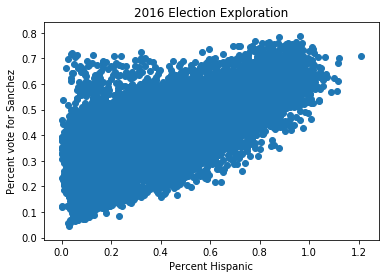

In [18]:
plt.title('2016 Election Exploration')
plt.scatter(output_sig['pct_hispanic'], output_sig['pct_sanchez'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Sanchez')

Text(0, 0.5, 'Percent vote for Prop 58')

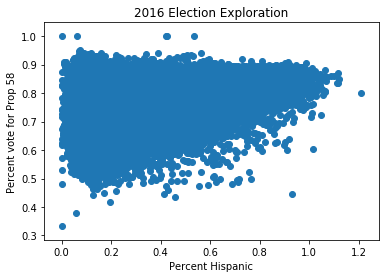

In [19]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_hispanic'], output['prop58_yes'] / (output['prop58_yes'] + output['prop58_no'])) 
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Prop 58')

Text(0, 0.5, 'Percent vote for Trump')

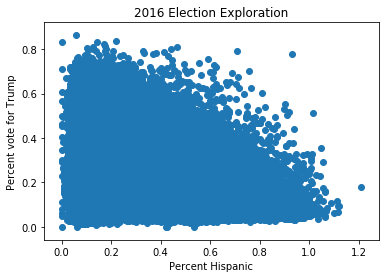

In [20]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_hispanic'], output['pct_trump'])
plt.xlabel('Percent Hispanic')
plt.ylabel('Percent vote for Trump')

In [21]:
mapping = pd.read_csv('county_code_map.csv')
mapping = mapping.set_index('FIPS_code') 
# hack - change this later to a dict or something


In [22]:
output.columns

Index(['OBJECTID', 'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes',
       ...
       'pct_prop58_yes', 'pct_prop59_yes', 'pct_prop60_yes', 'pct_prop61_yes',
       'pct_prop62_yes', 'pct_prop63_yes', 'pct_prop64_yes', 'pct_prop65_yes',
       'pct_prop66_yes', 'pct_prop67_yes'],
      dtype='object', length=149)

In [23]:
output_g = output[output['pct_hispanic'] > 0.05]
print(len(output_g))
output_g = output_g.dropna()
print(len(output_g))

X = np.array(output_g['pct_hispanic']).reshape(-1,1)
y = np.array(output_g['prop57_yes']) #pct_sanchez


output_g = output_g[reduce]

21828
21277


In [24]:
output_g.columns

Index(['pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity'],
      dtype='object')

In [25]:
F, pval  = f_regression(output_g, y.ravel())
pd.DataFrame(F,index=output_g.columns,columns=['linear correlation']).sort_values('linear correlation',ascending=False)#.head()

,linear correlation
prop57_yes,31938027357435744256.00
prop59_yes,1184405.66
prop61_yes,972732.50
prop58_yes,966492.72
prop56_yes,778891.49
prop64_yes,768701.06
prop52_yes,738101.48
prop63_yes,648207.40
prop66_no,577990.40
prop55_yes,513369.04


Text(0, 0.5, 'Percent vote for Trump')

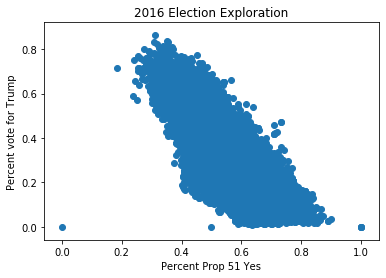

In [26]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_prop51_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 51 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
#     Total votes: 14,610,509
# Registered voters/turnout	19,411,771


Text(0, 0.5, 'Percent vote for Trump')

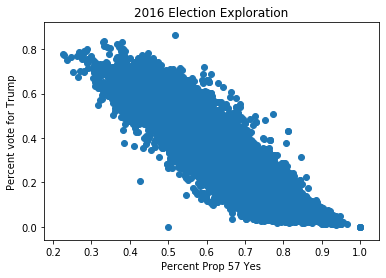

In [27]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_prop57_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 57 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
#     Total votes: 14,610,509
# Registered voters/turnout	19,411,771


Text(0, 0.5, 'Percent vote for Trump')

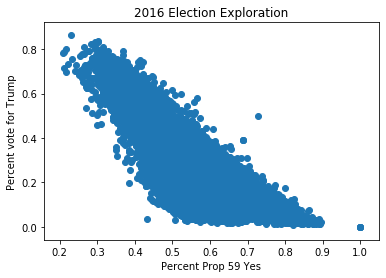

In [28]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_prop59_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 59 Yes')
plt.ylabel('Percent vote for Trump')

# FYI:
#     Total votes: 14,610,509
# Registered voters/turnout	19,411,771

Text(0, 0.5, 'Percent vote for Trump')

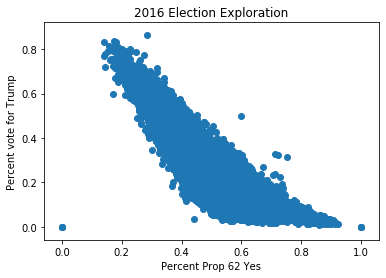

In [29]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_prop62_yes'], output['pct_trump'])
plt.xlabel('Percent Prop 62 Yes')
plt.ylabel('Percent vote for Trump')

Text(0, 0.5, 'Percent Black')

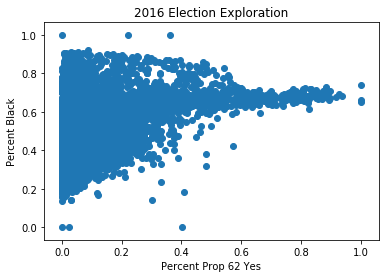

In [30]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_black'], output['pct_prop62_yes'])
plt.xlabel('Percent Prop 62 Yes')
plt.ylabel('Percent Black')

Text(0, 0.5, 'Percent Trump')

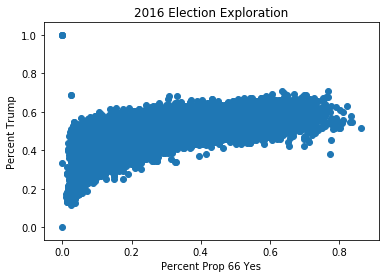

In [31]:
plt.title('2016 Election Exploration')
plt.scatter(output['pct_trump'], output['pct_prop66_yes'])
plt.xlabel('Percent Prop 66 Yes')
plt.ylabel('Percent Trump')

Text(0, 0.5, 'Percent Prop 67 Yes')

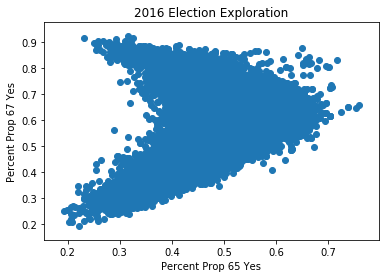

In [32]:
plt.title('2016 Election Exploration')
mask = (output[output['prop65_yes'] > 60])

plt.scatter(mask['pct_prop65_yes'], mask['pct_prop67_yes'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

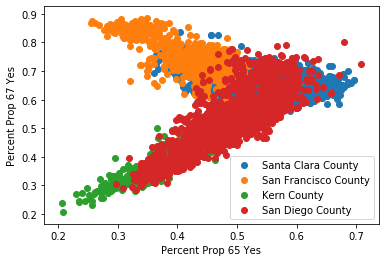

In [33]:
plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['pct_prop65_yes'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Francisco County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Francisco County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Kern County"]['pct_prop65_yes'], mask[mask['County Name'] == "Kern County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Diego County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Diego County"]['pct_prop67_yes'])
plt.legend(['Santa Clara County','San Francisco County', 'Kern County','San Diego County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

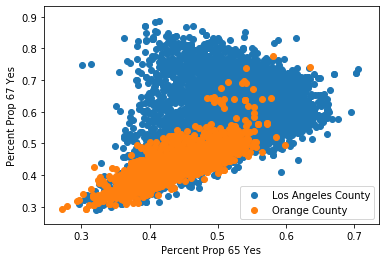

In [34]:
plt.scatter(mask[mask['County Name'] == "Los Angeles County"]['pct_prop65_yes'], mask[mask['County Name'] == "Los Angeles County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Orange County"]['pct_prop65_yes'], mask[mask['County Name'] == "Orange County"]['pct_prop67_yes'])
plt.legend(['Los Angeles County','Orange County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

Text(0, 0.5, 'Percent Prop 67 Yes')

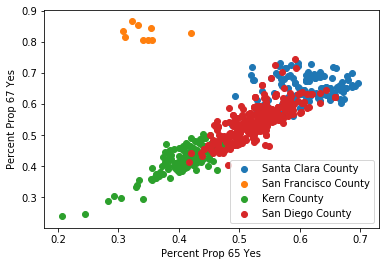

In [35]:
# new mask

mask = (output[output['pct_hispanic'] > .5])
mask = (mask[mask['prop65_yes'] > 60])

plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['pct_prop65_yes'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Francisco County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Francisco County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "Kern County"]['pct_prop65_yes'], mask[mask['County Name'] == "Kern County"]['pct_prop67_yes'])
plt.scatter(mask[mask['County Name'] == "San Diego County"]['pct_prop65_yes'], mask[mask['County Name'] == "San Diego County"]['pct_prop67_yes'])
plt.legend(['Santa Clara County','San Francisco County', 'Kern County','San Diego County'])
plt.xlabel('Percent Prop 65 Yes')
plt.ylabel('Percent Prop 67 Yes')

In [54]:
mask = (output[output['prop65_yes'] > 20])

# plt.scatter(mask[mask['County Name'] == "Santa Clara County"]['Estimates: Median household income in the past 12 months (in 2017 inflation-adjusted dollars)'], mask[mask['County Name'] == "Santa Clara County"]['pct_prop55_yes'])
# plt.scatter(mask[mask['County Name'] == "San Francisco County"]['Estimates: Median household income in the past 12 months (in 2017 inflation-adjusted dollars)'], mask[mask['County Name'] == "San Francisco County"]['pct_prop55_yes'])
# plt.scatter(mask[mask['County Name'] == "Orange County"]['Estimates: Median household income in the past 12 months (in 2017 inflation-adjusted dollars)'], mask[mask['County Name'] == "Orange County"]['pct_prop55_yes'])
# plt.scatter(mask[mask['County Name'] == "Kern County"]['Estimates: Median household income in the past 12 months (in 2017 inflation-adjusted dollars)'], mask[mask['County Name'] == "Kern County"]['pct_prop55_yes'])
# plt.scatter(mask[mask['County Name'] == "San Diego County"]['Estimates: Median household income in the past 12 months (in 2017 inflation-adjusted dollars)'], mask[mask['County Name'] == "San Diego County"]['pct_prop55_yes'])
# plt.legend(['Santa Clara County','San Francisco County', 'Orange County',Kern County','San Diego County'])

# plt.scatter(output['Estimates: Median household income in the past 12 months (in 2017 inflation-adjusted dollars)'], output['pct_prop55_yes'])

# Take these slices, reshape dataframe on that then calculate F and pval to see which counties are most similar


In [36]:
output['County Name'].value_counts()

Los Angeles County        6380
Orange County             1805
San Diego County          1775
San Bernardino County     1077
Santa Clara County        1056
Alameda County            1038
Riverside County          1014
Sacramento County          906
Contra Costa County        622
San Francisco County       577
Fresno County              575
San Mateo County           455
Kern County                441
Ventura County             422
San Joaquin County         391
Sonoma County              382
Santa Barbara County       306
Stanislaus County          300
Solano County              268
Tulare County              260
Monterey County            226
Placer County              205
Butte County               193
Santa Cruz County          185
Marin County               170
San Luis Obispo County     154
Merced County              140
El Dorado County           124
Shasta County              123
Yolo County                120
Humboldt County            104
Napa County                 98
Imperial

In [37]:
output.columns[:50]

Index(['OBJECTID', 'pres_clinton', 'pres_trump', 'pres_johnson', 'pres_stein',
       'pres_lariva', 'pres_other', 'ussenate_harris', 'ussenate_sanchez',
       'prop51_yes', 'prop51_no', 'prop52_yes', 'prop52_no', 'prop53_yes',
       'prop53_no', 'prop54_yes', 'prop54_no', 'prop55_yes', 'prop55_no',
       'prop56_yes', 'prop56_no', 'prop57_yes', 'prop57_no', 'prop58_yes',
       'prop58_no', 'prop59_yes', 'prop59_no', 'prop60_yes', 'prop60_no',
       'prop61_yes', 'prop61_no', 'prop62_yes', 'prop62_no', 'prop63_yes',
       'prop63_no', 'prop64_yes', 'prop64_no', 'prop65_yes', 'prop65_no',
       'prop66_yes', 'prop66_no', 'prop67_yes', 'prop67_no', 'votedensity',
       'STATE_FIPS', 'CNTY_FIPS', 'STCOFIPS', 'TRACT', 'BLKGRP', 'FIPS'],
      dtype='object')